https://www.tensorflow.org/datasets/catalog/

https://www.tensorflow.org/tutorials/images/segmentation

https://keras.io/examples/vision/oxford_pets_image_segmentation/

https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py

## Datsets
https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data/notebooks

https://www.kaggle.com/wangmo/self-driving-cars-road-segmentation-task

https://www.kaggle.com/bulentsiyah/semantic-drone-dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
% matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'

In [3]:
pet, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNTWKW2/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNTWKW2/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [5]:
type(pet['train'])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [6]:
images = list(pet['train'].map(lambda x: x['image']))
display(len(images))
display(images[0].shape, images[1].shape)

3680

TensorShape([500, 500, 3])

TensorShape([313, 500, 3])

In [7]:
segmentation_masks = list(pet['train'].map(lambda x: x['segmentation_mask']))
display(len(segmentation_masks))
display(segmentation_masks[0].shape, segmentation_masks[1].shape)

3680

TensorShape([500, 500, 1])

TensorShape([313, 500, 1])

In [8]:
labels = list(pet['train'].map(lambda x: x['label']))
display(len(labels))
display(labels[0], labels[1])

3680

<tf.Tensor: shape=(), dtype=int64, numpy=33>

<tf.Tensor: shape=(), dtype=int64, numpy=12>

In [9]:
species = list(pet['train'].map(lambda x: x['species']))
display(len(species))
display(species[0], species[1])

3680

<tf.Tensor: shape=(), dtype=int64, numpy=0>

<tf.Tensor: shape=(), dtype=int64, numpy=1>

species: tf.Tensor(1, shape=(), dtype=int64)
label: tf.Tensor(29, shape=(), dtype=int64)


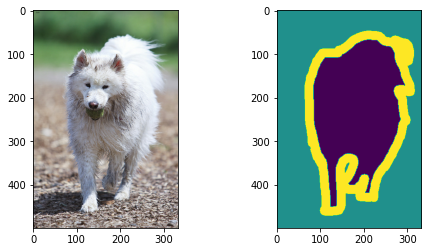

species: tf.Tensor(0, shape=(), dtype=int64)
label: tf.Tensor(7, shape=(), dtype=int64)


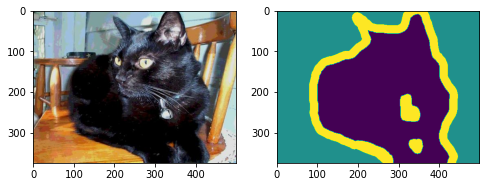

species: tf.Tensor(0, shape=(), dtype=int64)
label: tf.Tensor(33, shape=(), dtype=int64)


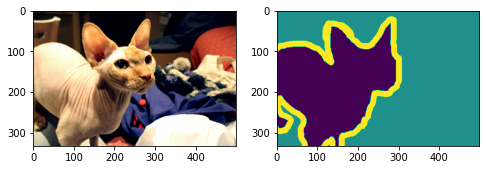

species: tf.Tensor(1, shape=(), dtype=int64)
label: tf.Tensor(19, shape=(), dtype=int64)


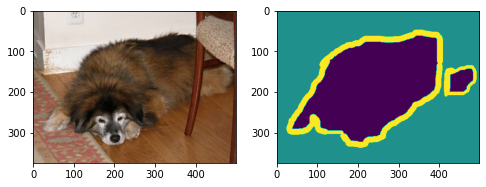

In [10]:
n_images = 4
for i in np.random.randint(0,len(images),n_images):
  print(f'species:',species[i])
  print(f'label:',labels[i])

  plt.figure(figsize = (8,4))
  plt.subplot(121)
  image = np.array(images[i])
  plt.imshow(image)

  plt.subplot(122)
  mask = np.array(segmentation_masks[i])
  mask = mask.reshape(mask.shape[0], mask.shape[1])
  plt.imshow(mask)
  plt.show()


In [11]:
mask = np.array(segmentation_masks[0])
print(mask.shape)
print(np.unique(mask))

mask-=1
print(mask.shape)
print(np.unique(mask))

(500, 500, 1)
[1 2 3]
(500, 500, 1)
[0 1 2]


## Create Dataset

In [25]:
img_size = (256,256)
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], img_size)
  input_mask = tf.image.resize(datapoint['segmentation_mask'], img_size)

  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1

  return input_image, input_mask 

In [26]:
train = pet['train'].map(load_image)
test = pet['test'].map(load_image)

print(train)
len(train), len(test)

<MapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.float32)>


(3680, 3669)

In [27]:
3680/64

57.5

In [28]:
TRAIN_LENGTH = len(train)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [29]:
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

In [32]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask = image, mask

print(sample_image.shape)
print('*'*50)
print(sample_mask.shape)

(64, 256, 256, 3)
**************************************************
(64, 256, 256, 1)


## Model building

In [20]:
from tensorflow.keras import layers
from tensorflow import keras

In [33]:
import math

def output_size(n,f, s=1, p=0):
  if p == 'same':
    p = 1
  return math.ceil((n - f + 2*p)/s + 1)

output_size(128,3,1,'same')

128

In [34]:
def downblock(filters, filter_size, previous_layer):
  x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  p = layers.MaxPooling2D(2)(x)

  return x,p

def bottleneck(filters, filter_size, previous_layer):
  x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  return x

def upblock(filters, filter_size, previous_layer, layer_to_concat):
  x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)       #upconvolution
  x = layers.concatenate([x, layer_to_concat])                                                      #concatenation
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  return x

In [90]:
input_layer = layers.Input(shape = img_size + (3,))

conv1, pool1 = downblock(32, 3, input_layer)
conv2, pool2 = downblock(64, 3, pool1)
conv3, pool3 = downblock(128, 3, pool2)

conv4 = bottleneck(256,3,pool3)

upconv1 = upblock(128, 3, conv4, conv3)
upconv2 = upblock(64, 3, upconv1, conv2)
upconv3 = upblock(32, 3, upconv2, conv1)

output_layer = layers.Conv2D(3, 1, padding="same", activation='softmax')(upconv3)
model = keras.Model(input_layer, output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

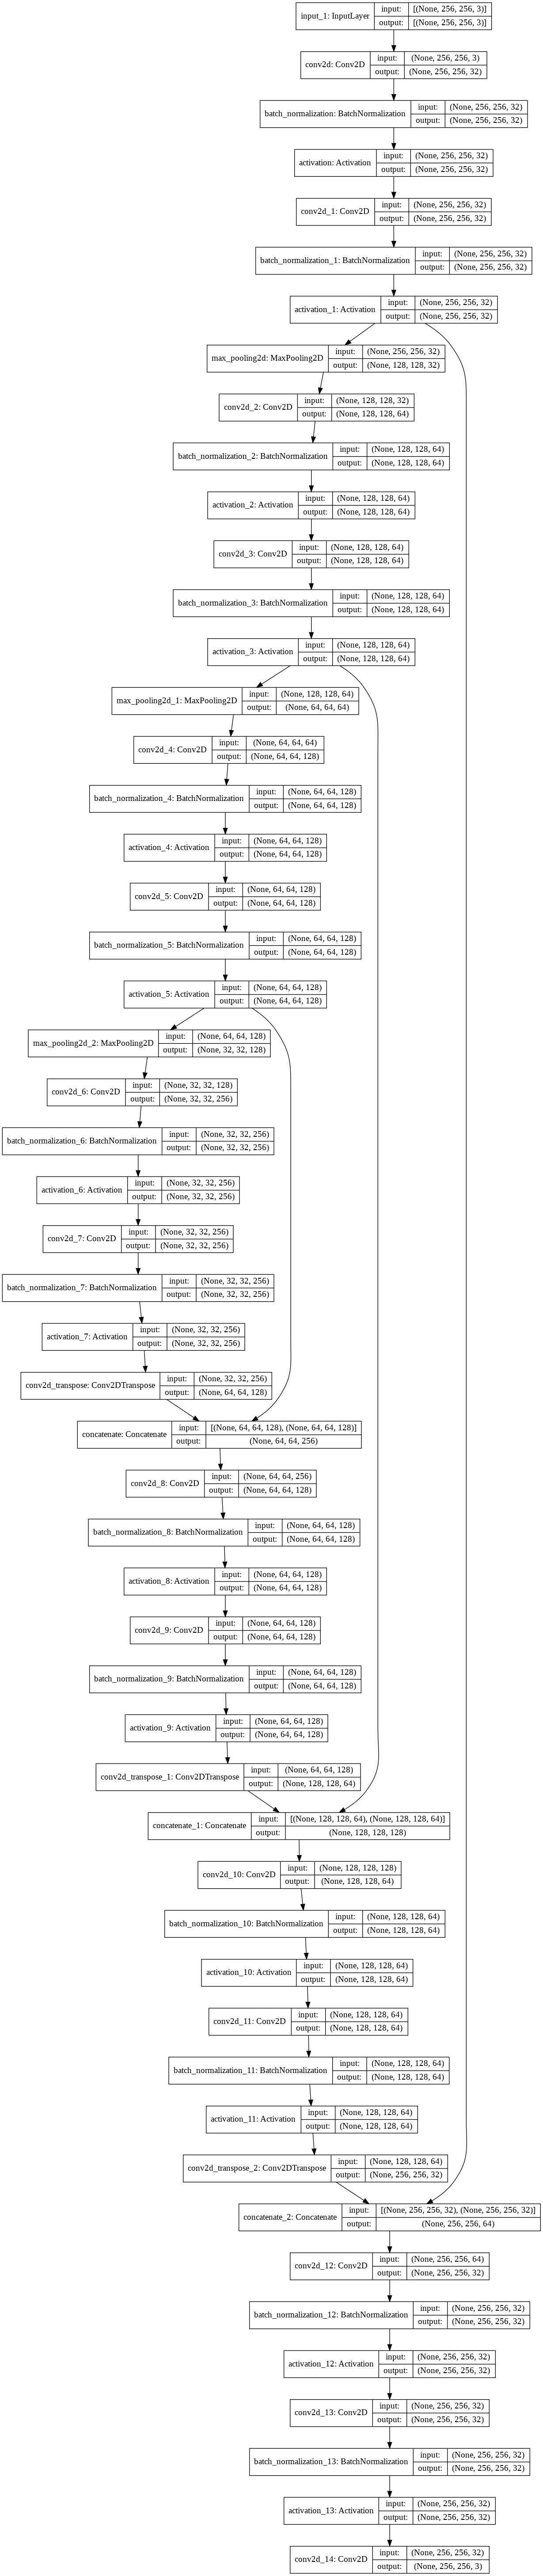

In [91]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [92]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss="sparse_categorical_crossentropy",
              metrics=['accuracy']) #tf.keras.metrics.MeanIoU(num_classes=2)

callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Image segmentation/oxford_segmentation_UNet.h5",
                                             save_best_only=True)]


In [94]:
# Train the model, doing validation at the end of each epoch.
epochs = 10
model_history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/10
58/58 [==============================] - 105s 2s/step - loss: 0.6106 - accuracy: 0.7367 - val_loss: 4.9965 - val_accuracy: 0.3666
Epoch 2/10
58/58 [==============================] - 105s 2s/step - loss: 0.5966 - accuracy: 0.7443 - val_loss: 1.1606 - val_accuracy: 0.6290
Epoch 3/10
58/58 [==============================] - 106s 2s/step - loss: 0.5760 - accuracy: 0.7546 - val_loss: 1.3750 - val_accuracy: 0.6267
Epoch 4/10
58/58 [==============================] - 106s 2s/step - loss: 0.5570 - accuracy: 0.7632 - val_loss: 1.2257 - val_accuracy: 0.6340
Epoch 5/10
58/58 [==============================] - 106s 2s/step - loss: 0.5377 - accuracy: 0.7723 - val_loss: 1.6958 - val_accuracy: 0.5714
Epoch 6/10
58/58 [==============================] - 105s 2s/step - loss: 0.5243 - accuracy: 0.7792 - val_loss: 1.2162 - val_accuracy: 0.6366
Epoch 7/10
58/58 [==============================] - 106s 2s/step - loss: 0.4961 - accuracy: 0.7933 - val_loss: 0.7629 - val_accuracy: 0.7070
Epoch 8/10
58

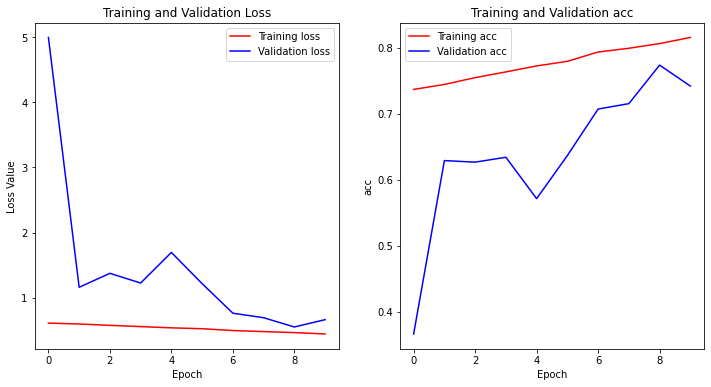

In [96]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, 'r', label='Training acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('acc')
plt.legend()

plt.show()

#Predictions

In [53]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [54]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [55]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in train_dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

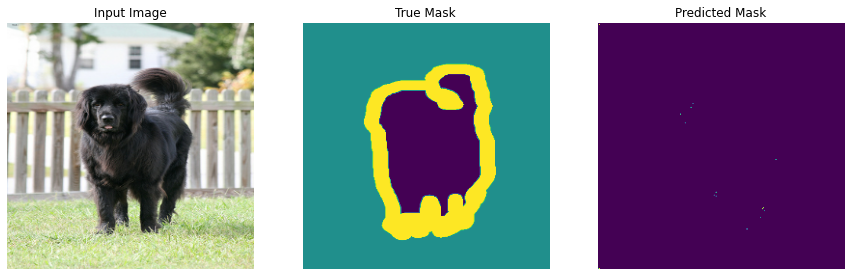

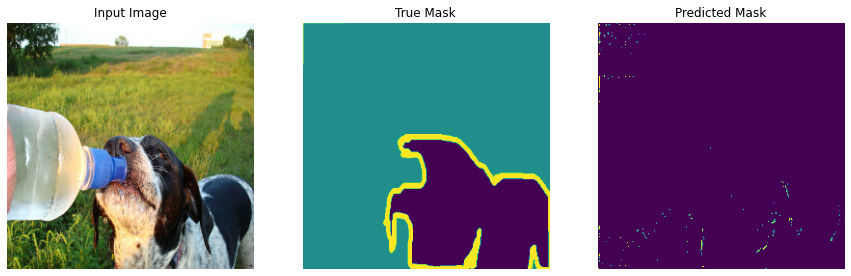

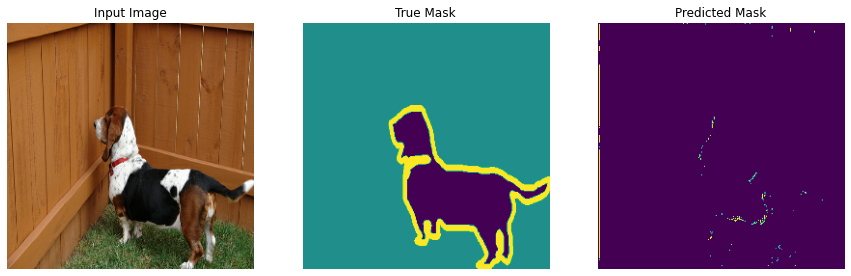

In [56]:
show_predictions(test_dataset, 3)

In [89]:
tf.keras.backend.clear_session()

# Residual block in UNet

<img src='https://miro.medium.com/max/5998/1*eKrh8FqJL3jodebYlielNg.png'>

In [95]:
def downblock(filters, filter_size, previous_layer):
  x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  x = layers.BatchNormalization()(x)
  
  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual

  x = layers.Activation("relu")(x)
  p = layers.MaxPooling2D(2)(x)

  return x,p

def bottleneck(filters, filter_size, previous_layer):
  x = layers.Conv2D(filters, filter_size, padding="same")(previous_layer)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)

  residual = layers.Conv2D(filters, 1, padding="same")(previous_layer)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  return x

def upblock(filters, filter_size, previous_layer, layer_to_concat):
  x = layers.Conv2DTranspose(filters, filter_size, strides=2, padding="same")(previous_layer)       #upconvolution
  concat = layers.concatenate([x, layer_to_concat])                                                      #concatenation

  x = layers.Conv2D(filters, filter_size, padding="same")(concat)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(filters, filter_size, padding="same")(x)
  x = layers.BatchNormalization()(x)

  residual = layers.Conv2D(filters, 1, padding="same")(concat)      #separate layer for addintion
  x = layers.add([x, residual])  # Add back residual
  
  x = layers.Activation("relu")(x)

  return x

In [ ]:
input_layer = layers.Input(shape = img_size + (3,))

conv1, pool1 = downblock(32, 3, input_layer)
conv2, pool2 = downblock(64, 3, pool1)
conv3, pool3 = downblock(128, 3, pool2)

conv4 = bottleneck(256,3,pool3)

upconv1 = upblock(128, 3, conv4, conv3)
upconv2 = upblock(64, 3, upconv1, conv2)
upconv3 = upblock(32, 3, upconv2, conv1)

output_layer = layers.Conv2D(3, 1, padding="same", activation='softmax')(upconv3)
model = keras.Model(input_layer, output_layer)
model.summary()